# GRU-RNN Modell mit den neu aufbereiteten Daten im Zuge der Thesis inklusive Wetterinformationen
Hierbei wurde ein GRU-RNN Modell trainiert mit den neu aufbereiteten Daten im Zuge dieser Thesis. Dabei wurden die Informationen über das Wetter in den Daten integriert um die Auswirkungen dieser erkennen zu können. Die Aufteilung in Trainings- und Testdaten ist hierbei im Dokument enthalten, da kein Shuffle enthalten ist und die Zeitreihendaten sortiert sind (Split immer an derselben Stelle). Man hätte diesen Prozess auslagern können, bedingt durch Google Colab war es jedoch einfacher den Prozess in den einzelnen Dokumenten zu behalten.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout, CuDNNGRU, CuDNNLSTM, Bidirectional
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     |████████████████████████████████| 98 kB 2.7 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
FILE_NAME = "data_with_weather.csv"
FS_ROOT_PATH = '/content/drive/MyDrive/sensalytics/Rohdaten/'
CSV_PATH = FS_ROOT_PATH + FILE_NAME

## Data-Import:

In [ ]:
dataset = pd.read_csv(filepath_or_buffer=CSV_PATH, index_col='Date_Time')
dataset.head(5)

,Ø Temperature,Visitor In,Visitor Out,Ø Occupancy,POS served,Ø Total Occupancy (Payer),Month,Weekday,Weekend,Hour,cloudy,misty,rainy,stormy,sunny
Date_Time,,,,,,,,,,,,,,,
2021-08-12 06:56:00,22.83,1,1,0,0,0,8,3,0,6,0,0,0,0,1
2021-08-12 06:58:00,22.83,0,1,0,2,0,8,3,0,6,0,0,0,0,1
2021-08-12 06:59:00,22.83,1,1,0,0,0,8,3,0,6,0,0,0,0,1
2021-08-12 07:00:00,22.83,2,0,1,0,0,8,3,0,7,0,0,0,0,1
2021-08-12 07:01:00,22.83,3,0,4,0,0,8,3,0,7,0,0,0,0,1


In [ ]:
dataset.index = pd.to_datetime(dataset.index)

Hier wird die Label-Spalte vom Dataset getrennt.

In [ ]:
y = dataset.pop('Ø Total Occupancy (Payer)')
display(y.head(5))

Date_Time
2021-08-12 06:56:00    0
2021-08-12 06:58:00    0
2021-08-12 06:59:00    0
2021-08-12 07:00:00    0
2021-08-12 07:01:00    0
Name: Ø Total Occupancy (Payer), dtype: int64

## Modell mit Sliding Window (Many-To-One trainieren):


Hier wird der Dataset in Trainings- und Testdaten eingeteilt. Dabei ist wichtig das Flag *shuffle=False* zu setzen, damit die Daten nicht gemischt werden. Danach werden die Daten mit Hilfe des **StandardScaler()** oder des **MinMaxScaler()** scaliert. Das verbessert das Training, da sich der Wertebereich der Features nicht so groß unterscheidet.

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(dataset, y, test_size=0.2, random_state=0, shuffle=False)

input_scaler = MinMaxScaler()

input_scaler.fit(train_x, train_y)

train_x = input_scaler.transform(train_x)
test_x = input_scaler.transform(test_x)

Die Eingabe für jede RNN-Schicht muss dreidimensional sein. <br>
Die drei Dimensionen dieser Eingabe sind:

- **Samples:** Eine Sequenz ist eine Probe. Eine Batch besteht aus einer oder mehreren Proben.
- **Time Steps:** Ein Zeitschritt ist ein Beobachtungspunkt in der Stichprobe.
- **Features.** Ein Merkmal ist eine Beobachtung pro Zeitschritt.

---

Im *Many-To-One*-Ansatz werden hier die Daten mit dem Sliding-Window verfahren angepasst. Hierbei werden die letzten **n** Timestamps genommen um die nächsten **m** Timestamps vorherzusagen. Mit der Funktion *to_supervised()* werden die Tranings- und Testdaten deshalb angepasst. 

In [ ]:
N_INPUT = 180
M_OUTPUT = 10
FEATURES = dataset.shape[1]
EPOCHS = 100
BATCH_SIZE = 128

In [ ]:
def to_supervised(data, label, n_input, output_ix):
	X, y = list(), list()
	ix_start = 0
	# step over the entire history one time step at a time
	for i in range(len(label)):
		# define the end of the input sequence
		ix_end = ix_start + n_input
		ix_output = ix_end + output_ix
		# ensure we have enough data for this instance
		if ix_output < len(label):
			X.append(data[ix_start:ix_end])
			y.append(label[ix_end:ix_output])
		# move along one time step
		ix_start += 1
	return np.array(X), np.array(y)

In [ ]:
train_x, train_y = to_supervised(train_x, train_y.values, N_INPUT, M_OUTPUT)
test_x, test_y = to_supervised(test_x, test_y.values, N_INPUT, M_OUTPUT)
print("train_x Shape:", train_x.shape)
print("train_y Shape:", train_y.shape)
print("test_x Shape:", test_x.shape)
print("test_y Shape:", test_y.shape)

train_x Shape: (67502, 180, 14)
train_y Shape: (67502, 10)
test_x Shape: (16733, 180, 14)
test_y Shape: (16733, 10)


Implementierung eines Modells ohne die Optimierung der Parameter zum Testen:

In [ ]:
# GRU-RNN Many-To-One Model
model_1 = Sequential()
model_1.add(GRU(64, input_shape=(N_INPUT, FEATURES)))
model_1.add(Dense(64))
model_1.add(Dense(M_OUTPUT))

model_1.compile(loss='mse', optimizer='Adam', metrics=['mae', 'mse'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                15360     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 20,170
Trainable params: 20,170
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model_1.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[early_stop])

Epoch 1/100
528/528 [==============================] - 12s 12ms/step - loss: 21.2373 - mae: 3.3915 - mse: 21.2373 - val_loss: 11.9608 - val_mae: 2.6599 - val_mse: 11.9608
Epoch 2/100
528/528 [==============================] - 5s 10ms/step - loss: 11.5623 - mae: 2.5918 - mse: 11.5623 - val_loss: 10.9912 - val_mae: 2.5458 - val_mse: 10.9912
Epoch 3/100
528/528 [==============================] - 6s 12ms/step - loss: 10.6738 - mae: 2.4905 - mse: 10.6738 - val_loss: 10.8419 - val_mae: 2.5673 - val_mse: 10.8419
Epoch 4/100
528/528 [==============================] - 5s 10ms/step - loss: 10.2468 - mae: 2.4412 - mse: 10.2468 - val_loss: 11.1356 - val_mae: 2.6155 - val_mse: 11.1356
Epoch 5/100
528/528 [==============================] - 5s 10ms/step - loss: 10.0504 - mae: 2.4193 - mse: 10.0504 - val_loss: 10.1427 - val_mae: 2.4474 - val_mse: 10.1427
Epoch 6/100
528/528 [==============================] - 5s 10ms/step - loss: 9.8330 - mae: 2.3948 - mse: 9.8330 - val_loss: 10.0813 - val_mae: 2.4098 

In [ ]:
loss, mae, mse = model_1.evaluate(test_x, test_y, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

523/523 - 2s - loss: 10.4680 - mae: 2.4784 - mse: 10.4680 - 2s/epoch - 4ms/step
Testing set Mean Abs Error:  2.48 MPG


In [ ]:
y_hat = model_1.predict(test_x)
y_hat = y_hat.clip(min=0)

In [ ]:
def calculate_metrics(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  rmsle = mean_squared_log_error(y_true, y_pred, squared=False)
  mae = mean_absolute_error(y_true, y_pred)
  med = median_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  
  return {'MSE': mse, 'RMSE': rmse, 'RMSLE': rmsle, 'MAE':mae, 'MED':med, 'R2':r2}

def evaluate_model(y_true, y_pred):
  df_scores = pd.DataFrame(columns=['MSE', 'RMSE', 'RMSLE', 'MAE', 'MED', 'R2'])

  # Berechnung der Metrics über die einzelnen Vorhersagen
  for i in range(y_true.shape[1]):
    score = pd.Series(calculate_metrics(y_true[:, i], y_pred[:, i]), name='min' + str(i+1) + ':')
    df_scores = df_scores.append(score)
  
  # Berechnugn der Metrics über alle Vorhersagen
  scores_total = pd.Series(calculate_metrics(y_true, y_pred), name='total:')
  df_scores= df_scores.append(scores_total)

  return df_scores

In [ ]:
df_scores = evaluate_model(test_y, y_hat)
display(df_scores)

,MSE,RMSE,RMSLE,MAE,MED,R2
min1:,9.610515,3.100083,0.415876,2.369995,1.857420,0.740499
min2:,9.937967,3.152454,0.426063,2.415318,1.900159,0.731689
min3:,10.173094,3.189529,0.428570,2.439915,1.916267,0.725374
min4:,10.417913,3.227679,0.430132,2.464581,1.927902,0.718792
min5:,10.551295,3.248276,0.438318,2.486839,1.932873,0.715218
min6:,10.673083,3.266969,0.439902,2.501645,1.951752,0.711957
min7:,10.746860,3.278240,0.443886,2.513271,1.981231,0.709997
min8:,10.796223,3.285761,0.445183,2.518154,1.980231,0.708701
min9:,10.867966,3.296660,0.448475,2.529217,1.999738,0.706802
min10:,10.895823,3.300882,0.449165,2.532183,1.999422,0.706086


In [ ]:
np.std(test_y)

6.087091183799563

In [ ]:
def plot_all_predictions(y_pred, y_true):
  # Flatten of the predictions, and get the every 10th
  prediction = y_pred.flatten()[0::10]
  true = y_true.flatten()[0::10]

  plt.figure(figsize=(25,8))
  plt.title("Vergleich der Vorhersagen:")
  plt.plot(true, color='orange', linestyle='-', label='True')
  plt.plot(prediction, color='green', linestyle='--', label='Pred')
  plt.xlabel('Minuten')
  plt.ylabel('Personen im Kassenbereich')
  plt.legend()
  plt.grid()
  plt.show()

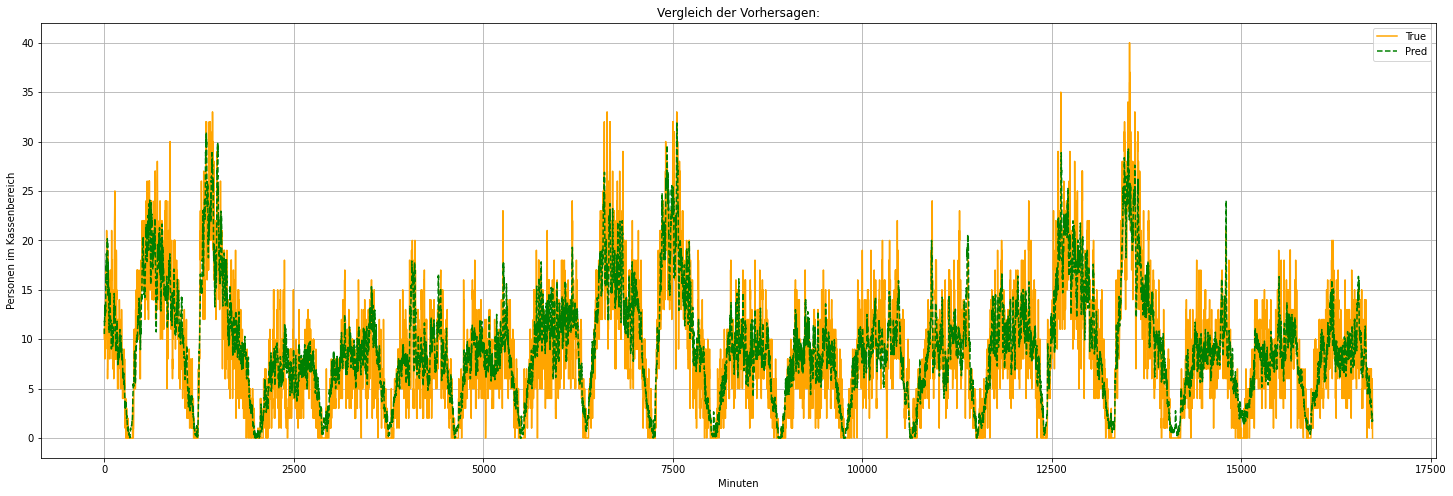

In [ ]:
plot_all_predictions(y_hat, test_y)

### Tuning der Hyperparameter mit Hilfe eines Keras Tuners:

In [ ]:
def build_model(hp):
  # Sequential Model:
  model = Sequential()

  # Input GRU-Layer with Input-Shape:
  model.add(GRU(
    units=hp.Int('layer_1_units',  min_value=8, max_value=128, step=8), 
    input_shape=(N_INPUT, FEATURES),
    return_sequences=True
  ))

  # Second GRU-Layer
  model.add(GRU(
    units=hp.Int('layer_2_units', min_value=8, max_value=128, step=8)
  ))

  # Dropout-Layer:
  if hp.Boolean('dropout'):
    model.add(
      Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, default=0.0, step=0.1)
    ))

  # Dense Layer with units:
  model.add(Dense(
    units=hp.Int('units_dense', min_value=32, max_value=512, step=32)
  ))

  # Dense Layer with Output-Shape:
  model.add(Dense(
    units=M_OUTPUT
  ))

  # Configuration of optimizer and learnrate:
  model.compile(
    loss = 'mse', 
    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])),  
    metrics=['mae', 'mse'])  

  return model

#### RandomSearch:

In [ ]:
ran_tuner = kt.RandomSearch(hypermodel=build_model, objective="val_loss", max_trials=75, seed=1111, project_name="ran_project")
ran_tuner.search_space_summary()

Search space summary
Default search space size: 5
layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
layer_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
units_dense (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
ran_tuner.search(train_x, train_y, validation_data=(test_x, test_y), epochs=EPOCHS, batch_size=128, callbacks=[early_stop, keras.callbacks.TensorBoard("/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/tmp/new/tb_logs_ran_wet")])

# Retrieve the best model.s
ran_model = ran_tuner.get_best_models(num_models=1)[0]

Trial 75 Complete [00h 01m 11s]
val_loss: 10.63609790802002

Best val_loss So Far: 9.989705085754395
Total elapsed time: 02h 42m 08s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get best parameters
ran_parameters = ran_tuner.get_best_hyperparameters(num_trials=1)[0]

ran_parameters.values

{'dropout': True,
 'dropout_rate': 0.4,
 'layer_1_units': 80,
 'layer_2_units': 72,
 'learning_rate': 0.001,
 'units_dense': 352}

In [ ]:
ran_model.save('/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/ran_model_wet')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/ran_model_wet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/ran_model_wet/assets


#### BayesianOptimazation:

In [ ]:
bay_tuner = kt.BayesianOptimization(build_model, max_trials=75, objective='val_loss', seed=1112, project_name="bay_project")
bay_tuner.search_space_summary()

Search space summary
Default search space size: 5
layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
layer_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
units_dense (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
bay_tuner.search(train_x, train_y, validation_data=(test_x, test_y), epochs=EPOCHS, batch_size=128, callbacks=[early_stop, keras.callbacks.TensorBoard("/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/tmp/new/tb_logs_bay_wet")])

# Retrieve the best model.s
bay_model = bay_tuner.get_best_models(num_models=1)[0]

Trial 75 Complete [00h 01m 27s]
val_loss: 10.284611701965332

Best val_loss So Far: 9.873111724853516
Total elapsed time: 02h 44m 24s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get best parameters
bay_parameters = bay_tuner.get_best_hyperparameters(num_trials=1)[0]

bay_parameters.values

{'dropout': False,
 'dropout_rate': 0.2,
 'layer_1_units': 104,
 'layer_2_units': 56,
 'learning_rate': 0.0001,
 'units_dense': 320}

In [ ]:
bay_model.save('/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/bay_model_wet')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/bay_model_wet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/bay_model_wet/assets


#### Hyperband:

In [ ]:
hyp_tuner = kt.Hyperband(hypermodel=build_model, objective='val_mse', max_epochs=75, seed=1113)
hyp_tuner.search_space_summary()

Search space summary
Default search space size: 5
layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
layer_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
units_dense (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
hyp_tuner.search(train_x, train_y, validation_data=(test_x, test_y), batch_size=128, callbacks=[early_stop, keras.callbacks.TensorBoard("/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/tmp/new/tb_logs_hyp_wet")])

# Retrieve the best model.s
hyp_model = hyp_tuner.get_best_models(num_models=1)[0]

Trial 90 Complete [00h 01m 49s]
val_mse: 37.098575592041016

Best val_mse So Far: 9.87257194519043
Total elapsed time: 01h 53m 48s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get best parameters
hyp_parameters = hyp_tuner.get_best_hyperparameters(num_trials=1)[0]

hyp_parameters.values

In [ ]:
hyp_model.save('/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/hyp_model_wet')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/hyp_model_wet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/hyp_model_wet/assets
